In [1]:
from analysis_classes import *
import os

dataset_directory = "../csv_to_protobuf_bin/binary_logs/AWS_FXS/"

dtns_data_tmp = os.listdir(dataset_directory)

labels_ = "89"
dtns_data = []

for i in dtns_data_tmp:
    # if labels_ in i:
    #     dtns_data.append(i)
    dtns_data.append(i)
print(dtns_data)
print(dtns_data[3])

['series3', 'series5', 'series1', 'series6']
series6


In [2]:

print("Data in directory {} is\t{}".format(dataset_directory, len(dtns_data)))
dtns_df = TransferAnalysis(dataset_directory+dtns_data[3]).df
print("Dataframe shape for dtns dataset: {}".format(dtns_df.shape))

Data in directory ../csv_to_protobuf_bin/binary_logs/AWS_FXS/ is	4
Dataframe shape for dtns dataset: (8818, 59)


In [3]:
# print(dtns_df.loc[0].get("avg_rtt_value"))
# for i in range(len(dtns_df.loc[0].index)):
#     print(dtns_df.loc[0].index[i], dtns_df.loc[0].get(dtns_df.loc[0].index[i]))

In [3]:
def train_test_split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    x = df.drop(df.columns[len(df.columns)-1],axis=1)
    y = df[df.columns[len(df.columns)-1]]
    # total_labels = len(dict(Counter(y)))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [4]:
print(len(dict(Counter(dtns_df[dtns_df.columns[len(dtns_df.columns)-1]]))))
# a, b, c, d = train_test_split_df(dtns_df)

56


In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
# Running a model with a data set default model is random forest
a = Model_Run()
x_dtns_train, x_dtns_test, y_dtns_train, y_dtns_test = train_test_split_df(dtns_df)
print("Accuracy of the model {} is".format(a.model_to_name[a.model_name]), a.run_model(dtns_df))

rf_model = a.generate_with_all(x_dtns_train, y_dtns_train)
y_predicted = rf_model.predict(x_dtns_test)


from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_dtns_test, y_predicted, labels=rf_model.classes_)
matrix.shape

# fig, ax = plt.subplots(figsize=(10, 10))
# disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf_model.classes_)
# disp.plot()
# plt.show()

Accuracy of the model Random Forest is 0.9603174603174603


(56, 56)

In [6]:
import time
import numpy as np

start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: " f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.011 seconds


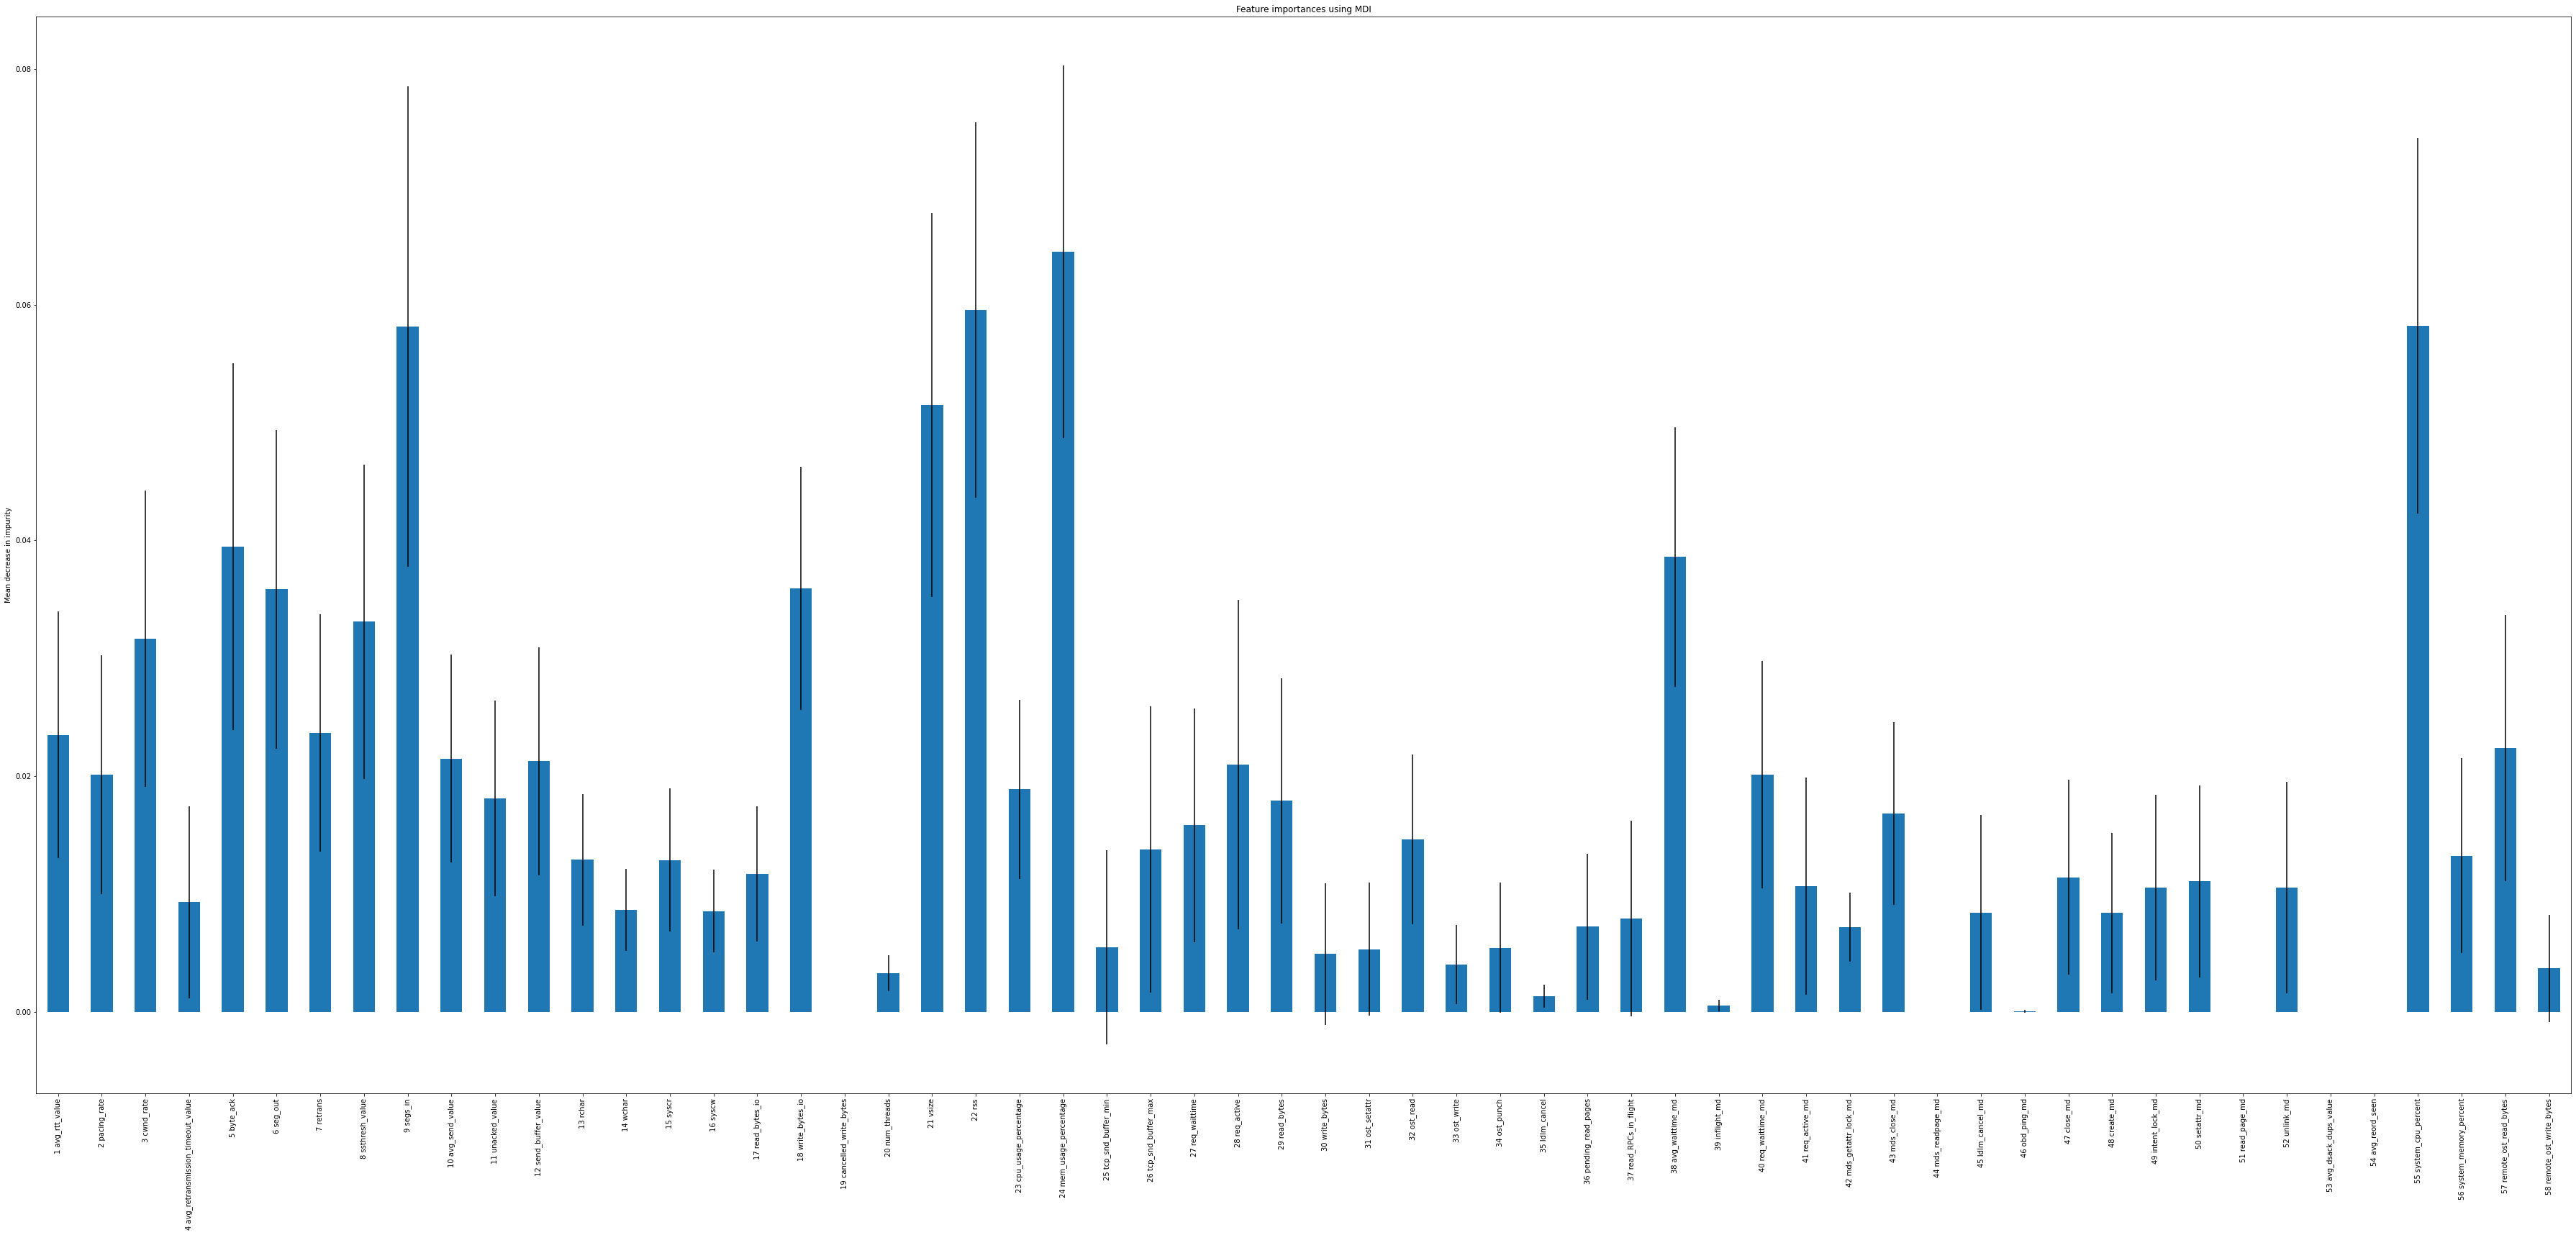

In [7]:
import pandas as pd
feature_names = [str(i+1) + " " + str(j) for i,j in enumerate(dtns_df.columns[:-1]) ]
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(50, 25)
fig.savefig('test_importance_15.jpeg', dpi=100)
fig.tight_layout()

In [ ]:
# Creating a model (classifier) with train dataset
# self.model_to_name = {"RF": "Random Forest", "DT": "Decision Tree", "MLP": "MLP Classifier",
#                       "KN": "KNeighborsClassifier", "QDA": "QuadraticDiscriminantAnalysis", "NB": "GaussianNB",
#                       "ADA": "AdaBoostClassifier", "svm": "SVM", "sdg": "SGDClassifier"}
data_set_1_classifier = a.generate_with_all(x_dtns_train, y_dtns_train, model_name="RF")
data_set_2_classifier = a.generate_with_all(x_dtns_train, y_dtns_train)

#Comparing the accuracy of model on different dataset
a.compare_two_dataset(dtns_df, dtns_df, model_name="RF")


In [ ]:
# dtns_df.describe()
dtns_df.iloc[:,14:30].describe()

In [ ]:
# Get the correlation of the data
correlation = dtns_df.corr()
f, axes = plt.subplots(figsize=(40,20))
#diverging color map generate
cmap = sns.diverging_palette(150, 275, as_cmap = True)

sns.heatmap(correlation, cmap= cmap, center = 0, linewidth = 1, cbar_kws={"shrink": 0.5})

plt.title('Correlation Matrix Heatmap')

In [ ]:
#Get the columns name in the dataset
dtns_df.columns

In [ ]:
#Cahnge Nans in correlation with false and true, get the name of the columns that have correlation true.
nan_corr = list(correlation.cwnd_rate[~correlation.loc[ ['cwnd_rate'] , : ].isna().any()].index.values)


In [ ]:
sns.pairplot(x_vars = nan_corr, y_vars = 'cwnd_rate', data = dtns_df.loc[dtns_df['label_value'] == 0], height=5)
plt.show()